# Load Data

In [1]:
%load_ext autoreload
%autoreload 2
from load import load_3D
from liftpose.vision_3d import XY_coord, Z_coord
import yaml
import logging
from imp import reload
import torch
import numpy as np
import matplotlib.pyplot as plt
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir' : "/data/LiftPose3D/fly_prism/data_oriented/training_data", # change the path 
       'out_dir'        : './out',
       "train_subjects": ["001", "002", "003"],
       'test_subjects'  : ["004"],
       'actions'        : ['PR']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# load data
train, train_keypts, _ = load_3D(par["data_dir"], subjects=par['train_subjects'], actions=par['actions'])
test,  test_keypts, _ = load_3D( par["data_dir"], subjects=par['test_subjects'],  actions=par['actions'])
#project data to ventral view
train_2d, train_3d = XY_coord(train), Z_coord(train)
test_2d, test_3d  = XY_coord(test), Z_coord(test)

# Train LiftPose3D Network on DeepFly3D Data

In [2]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts, 
           **{k:par[k] for k in ['roots', 'target_sets', 'out_dir']})

[main.py:163]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/fly_prism/out/stat_2d.pth.tar.
[main.py:185]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/fly_prism/outstat_3d.pth.tar.
[main.py:212]:INFO:Starting training model
[main.py:221]:DEBUG:
==================Options=================
[main.py:222]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 100000,
    'lr_gamma': 0.96,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:223]:DEBUG:=====================================

Epoch 0 | Loss Test 0 | Loss Train 1.3791|: 100%|██████████| 161/161 [00:02<00:00, 58.59it/s]
Epoch 1 | Loss Test 1.0879 | Loss Train 0.43789|: 100%|██████████| 161/161 [00:02<00:00, 63.52it/s]
Epoch 2 | Loss Test 0.75701 | Loss Train 0.16229|: 100%|██████████| 161/161 [00:02<00:00, 64.13it/s]
Epoch 3 | Loss Test 0.74522 | Loss Train 0.077791|: 100%|██████████| 161/161 [00:02<00:00, 66.80it/s]
Epoch 4 | Loss Test 0.73605 | Loss Train 0.045153|: 100%|██████████| 161/161 [00:02<00:00, 69.45it/s]
Epoch 5 | Loss Test 0.71769 | Loss Train 0.031744|: 100%|██████████| 161/161 [00:02<00:00, 63.16it/s]
Epoch 6 | Loss Test 0.67232 | Loss Train 0.027515|: 100%|██████████| 161/161 [00:02<00:00, 63.33it/s]
Epoch 7 | Loss Test 0.65041 | Loss Train 0.025666|: 100%|██████████| 161/161 [00:02<00:00, 69.62it/s]
Epoch 8 | Loss Test 0.65593 | Loss Train 0.024883|: 100%|██████████| 161/161 [00:02<00:00, 60.19it/s]
Epoch 9 | Loss Test 0.69085 | Loss Train 0.023106|: 100%|██████████| 161/161 [00:02<00:00, 71

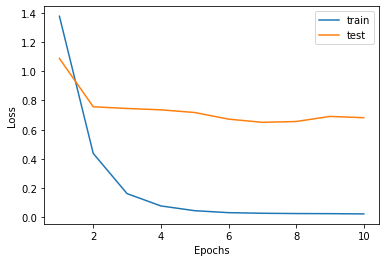

In [3]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [4]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:245]:INFO:starting testing in path: ./out
[lift.py:30]:INFO:Training on the device: cuda:0
[lift.py:58]:INFO:total params: 4.28M
[lift.py:64]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:72]:INFO:ckpt loaded (epoch: 7 | err: 0.9671621892648012)
[lift.py:110]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/fly_prism/out/test_results.pth.tar


# Visualize Predictions

In [6]:
from liftpose.postprocess import load_test_results
data = torch.load(par['out_dir'] + "/test_results.pth.tar")
stat_2d, stat_3d = (
    torch.load(par['out_dir'] + "/stat_2d.pth.tar"),
    torch.load(par['out_dir'] + "/stat_3d.pth.tar"),
)
test_3d_gt, test_3d_pred = load_test_results(data, stat_2d, stat_3d)

In [20]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
from liftpose.preprocess import add_roots
#%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=200, azim=60)

t = 1000
plot_pose_3d(ax, test_3d_gt[t],
            test_3d_pred[t], 
            par_data["vis"]["bones"], 
            par_data["vis"]["limb_id"], 
            par_data["vis"]["colors"],
            good_keypts=add_roots(data['good_keypts'], stat_3d["targets_3d"], len(stat_3d["mean"]))[t])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …